In [1]:
from cdm_datasetmaker import Get_datasets
datasets = Get_datasets(CONFIG_FOLDER_PATH = '../../TEST/CONFIG/',
                        DATA_FOLDER_PATH = '../../TEST/DATA/',
                        RESULT_FOLDER_PATH = '../../TEST/RESULT/',
                        PROJECT_NAME = 'emb_test',
                        DB_CONN_FILENAME = 'DB_connection.txt',
                        DS_PARAMS_FILE_NAME = 'DS_PARAMS.txt', 
                        PIPELINE_START_LEVEL = 4)



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

2018-09-27 11:26:55.561954

[Start Logging..]



 (params) 



[Level 4] Multihot to Dataset


2018-09-27 11:26:55.568109

  [multihot_to_datasets]

Loading at.. ../../TEST/DATA/t_pid_list.pkl
Loading at.. ../../TEST/DATA/t_seq_data.pkl
Loading at.. ../../TEST/DATA/t_demo_data.pkl
Loading at.. ../../TEST/DATA/t_seq_len.pkl
Loading at.. ../../TEST/DATA/c_pid_list.pkl
Loading at.. ../../TEST/DATA/c_seq_data.pkl
Loading at.. ../../TEST/DATA/c_demo_data.pkl
Loading at.. ../../TEST/DATA/c_seq_len.pkl

Number of T: 3335
Number of C: 20010

    (Split data)

    (Making datasets)

[Datasets Info.]

                  [OPTION]   [VALUE]
              CDM_DB_NAME:   NHIS_NSC
       CONFIG_FOLDER_PATH:   ../../TEST/CONFIG/
         DATA_FOLDER_PATH:   ../../TEST/DATA/
         DB_CONN_FILENAME: 

In [1]:
import os, sys, logging, datetime

param_dict = dict()
param_dict['DATA_FOLDER_PATH'] = '../../../NEW/cdm_datasetmaker/DATA/'
param_dict['RESULT_FOLDER_PATH'] = './RESULT/'

if not os.path.exists(param_dict['RESULT_FOLDER_PATH']): os.makedirs(param_dict['RESULT_FOLDER_PATH'])

## logger
rootlogger = logging.getLogger()
rootlogger.setLevel(logging.INFO)
# log_stream
stream_hander = logging.StreamHandler(sys.stdout)
rootlogger.addHandler(stream_hander)
# log_file    
param_dict['LOG_PATH'] = os.path.join('./RESULT', 'test_pipeline.log')
file_handler = logging.FileHandler(filename=param_dict['LOG_PATH'])
rootlogger.addHandler(file_handler)

In [2]:
import cdm_datasetmaker 

In [3]:
t_data, c_data = cdm_datasetmaker.multihot2datasets.load_data(rootlogger, param_dict['DATA_FOLDER_PATH'])

Loading at.. ../../../NEW/cdm_datasetmaker/DATA/t_pid_list.pkl
Loading at.. ../../../NEW/cdm_datasetmaker/DATA/t_seq_data.pkl
Loading at.. ../../../NEW/cdm_datasetmaker/DATA/t_demo_data.pkl
Loading at.. ../../../NEW/cdm_datasetmaker/DATA/t_seq_len.pkl
Loading at.. ../../../NEW/cdm_datasetmaker/DATA/c_pid_list.pkl
Loading at.. ../../../NEW/cdm_datasetmaker/DATA/c_seq_data.pkl
Loading at.. ../../../NEW/cdm_datasetmaker/DATA/c_demo_data.pkl
Loading at.. ../../../NEW/cdm_datasetmaker/DATA/c_seq_len.pkl

Number of T: 3335
Number of C: 20010


In [6]:
from scipy.sparse import csr_matrix
import numpy as np

rid_list = [0,0,1,1,1,2,3,3]
cid_list = [0,1,0,1,2,4,3,0]
data = [1,1,1,1,1,1,1,1]
seq_len = max(rid_list)+1
m = csr_matrix((data, (rid_list, cid_list)), shape=(10, 5))
m.toarray()

array([[1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=int64)

In [3]:
%%writefile emb_dataset.py

from utils import dumpingFiles, loadingFiles, option_printer

def edge_extractor(logger, seq_data, seq_len, left_context_size, right_context_size, directed):
    import pandas as pd
    from collections import defaultdict
    edge_dict = defaultdict(float)
    
    data_len = len(seq_len)
    printBy = int(data_len/10)
    for i, (sprs_m, l) in enumerate(zip(seq_data, seq_len)):
        if (((i+1)%printBy)==0) or i==0: 
            logger.info("  ..({}/{})".format(i+1, data_len))
        vseq = sprs_m[:l]
        source_size = vseq.shape[0]
        for s_idx in range(source_size):
            source_list = vseq[s_idx].indices
            # in visit
            for s1 in source_list:
                for s2 in source_list:
                    discounted_value = 1
                    if s1 != s2:
                        edge_dict[(s1, s2)] += discounted_value
            # between visits
            target = vseq[s_idx]
            left_context_list = vseq[max(0,s_idx-left_context_size) : s_idx]
            right_context_list = vseq[s_idx+1 : min((s_idx+right_context_size)+1, source_size)]
            #left
            for idx, contexts in enumerate(left_context_list[::-1]):
                discounted_value = 1/(idx+1)
                for t in target.indices:
                    for c in contexts.indices:
                        edge_dict[(t, c)] += discounted_value
            #right
            for idx, contexts in enumerate(right_context_list):
                discounted_value = 1/(idx+1)
                for t in target.indices:
                    for c in contexts.indices:
                        edge_dict[(t, c)] += discounted_value

    if not directed:
        new_dict = dict()
        for (t, c), v in edge_dict.items():
            if (c, t) in new_dict.keys():
                new_dict[(c, t)] += v
            else:
                new_dict[(t, c)] = v
        edge_dict = new_dict
    
    df_edge = pd.DataFrame([[s, t, v] for (s, t), v in edge_dict.items()], 
                           columns=['source', 'target', 'value']).astype({'source':'int', 'target':'int'})
    return df_edge

class Graph_DataSet():
    def __init__(self, df, code2idx):
        self._num_examples = len(df)
        self._epochs_completed = 0
        self._index_in_epoch = 0
        self.code2idx = code2idx
        self.targets = df.iloc[:,0].values
        self.contexts = df.iloc[:,1].values
        self.scaled_scores = df.iloc[:,2].values
         
    def _shuffle(self, targets, contexts, scaled_scores):
        import sklearn as sk
        return sk.utils.shuffle(targets, contexts, scaled_scores)
    
    def get_adj_matrix(self):
        import numpy as np
        adj_matrix = np.zeros([len(self.code2idx), len(self.code2idx)])
        for t, c, v in zip(self.targets, self.contexts, self.scaled_scores):
            adj_matrix[t, c] = v
            adj_matrix[c, t] = v
        return adj_matrix

    def next_batch(self, batch_size):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        end = self._index_in_epoch
        if end<=self._num_examples:
            return self.targets[start:end], self.contexts[start:end], self.scaled_scores[start:end]
        else:
            self._epochs_completed += 1
            num_of_short = batch_size-(self._num_examples-start)
            num_of_extra_batch = num_of_short // self._num_examples
            num_of_extra_example = num_of_short % self._num_examples
            self._epochs_completed += num_of_extra_batch
            self._index_in_epoch = num_of_extra_example

            tmp_targets=self.targets[start:]; tmp_contexts=self.contexts[start:]; tmp_scaled_scores=self.scaled_scores[start:]      
            self.targets, self.contexts, self.scaled_scores = self._shuffle(self.targets, self.contexts, self.scaled_scores)
            batch_targets = np.concatenate([tmp_targets]+[self.targets]*num_of_extra_batch
                                           +[self.targets[0:num_of_extra_example]], axis=0)
            batch_contexts = np.concatenate([tmp_contexts]+[self.contexts]*num_of_extra_batch
                                            +[self.contexts[0:num_of_extra_example]], axis=0)
            batch_scaled_scores = np.concatenate([tmp_scaled_scores]+[self.scaled_scores]*num_of_extra_batch
                                                 +[self.scaled_scores[0:num_of_extra_example]], axis=0)
            return batch_targets, batch_contexts, batch_scaled_scores 

def Get_emb_dataset(**kwargs):
    import logging, datetime, os
    logger = logging.getLogger('emb_dataset')
    if not os.path.exists(kwargs['RESULT_FOLDER_PATH']): os.makedirs(kwargs['RESULT_FOLDER_PATH'])
    file_handler = logging.FileHandler(filename=os.path.join(kwargs['RESULT_FOLDER_PATH'], 'emb_dataset.log'))
    logger.addHandler(file_handler)
    logger.info("\n{}".format(datetime.datetime.now()))
    logger.info("[Get_emb_dataset]")
    
    #extracting df_edge
    if kwargs['SKIP_EDGE_EXTRACTING']:
        logger.info("\n  (skip edge_extracting)")
        df_edge = loadingFiles(logger, kwargs['DATA_FOLDER_PATH'], 'df_edge.pkl')
    else:
        logger.info("\n  (extracting df_edge)")
        seq_data = loadingFiles(logger, kwargs['DATA_FOLDER_PATH'], 't_seq_data.pkl') + loadingFiles(logger, kwargs['DATA_FOLDER_PATH'], 'c_seq_data.pkl')
        seq_len = loadingFiles(logger, kwargs['DATA_FOLDER_PATH'], 't_seq_len.pkl') + loadingFiles(logger, kwargs['DATA_FOLDER_PATH'], 'c_seq_len.pkl')
        df_edge = edge_extractor(logger, seq_data, seq_len, kwargs['LEFT_CONTEXT_SIZE'], kwargs['RIGHT_CONTEXT_SIZE'], kwargs['DIRECTED'])
        #ceiling and scaling.
        dumpingFiles(logger, kwargs['DATA_FOLDER_PATH'], 'df_edge.pkl', df_edge)
    
    #make dataset
    logger.info("\n  (make emb_dataset)")
    code2idx = loadingFiles(logger, kwargs['DATA_FOLDER_PATH'], 'code2idx.pkl')
    dataset = Graph_DataSet(df_edge, code2idx)
    dataset.info = dict()
    dataset.info['DATA_FOLDER_PATH'] = kwargs['DATA_FOLDER_PATH']
    dataset.info['RESULT_FOLDER_PATH'] = kwargs['RESULT_FOLDER_PATH']
    dataset.info['LEFT_CONTEXT_SIZE'] = kwargs['LEFT_CONTEXT_SIZE']
    dataset.info['RIGHT_CONTEXT_SIZE'] = kwargs['RIGHT_CONTEXT_SIZE']
    dataset.info['DIRECTED'] = kwargs['DIRECTED']
    dataset.info['FEATURE_SIZE'] = len(code2idx)
    return dataset
    
    

Overwriting emb_dataset.py


In [1]:
param_dict = dict()
param_dict['RESULT_FOLDER_PATH'] = '../../cdm_datasetmaker/RESULT/'

import logging, datetime, sys, os

## logger
rootlogger = logging.getLogger()
rootlogger.setLevel(logging.INFO)
# log_stream
stream_hander = logging.StreamHandler(sys.stdout)
rootlogger.addHandler(stream_hander)
# log_file    
param_dict['LOG_PATH'] = os.path.join(param_dict['RESULT_FOLDER_PATH'], 'medterm2vec_pipeline.log')
file_handler = logging.FileHandler(filename=param_dict['LOG_PATH'])
rootlogger.addHandler(file_handler)
rootlogger.info("\n\n" + "@"*100 + "\n" + "@"*100)
rootlogger.info("\n\n{}\n[Pipeline Started..]\n\n".format(datetime.datetime.now()))


## Get_dataset

#from .utils import option_printer
#rootlogger.info("\n[Datasets Info.]\n")
#option_printer(rootlogger, **param_dict['DATASETS'].info)




@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


2018-09-12 23:36:51.142612
[Pipeline Started..]




In [1]:
from emb_dataset import Get_emb_dataset

emb_dataset = Get_emb_dataset(DATA_FOLDER_PATH = '../../cdm_datasetmaker/DATA/',
                              RESULT_FOLDER_PATH = '../../cdm_datasetmaker/RESULT/',
                              LEFT_CONTEXT_SIZE = 2,
                              RIGHT_CONTEXT_SIZE = 2,
                              DIRECTED = False,
                              SKIP_EDGE_EXTRACTING = True)

In [6]:
%%writefile ../CONFIG/EMB_PARAMS.txt
# about edge_extracting
CDM_DB_NAME = NHIS_NSC
LEFT_CONTEXT_SIZE = 2
RIGHT_CONTEXT_SIZE = 2
DIRECTED = False

# about emb_model
MODEL_ARCH = LINE_MODEL
BATCH_SIZE = 128
EMB_SIZE = 32, 64
LR_p1 = 5e-1, 5e-2
LR_p2 = 5e-2
DECAY_STEPS = 1000
DECAY_RATE = 0.9
TRAIN_STEPS_p1 = 1000
TRAIN_STEPS_p2 = 1000
PRINT_BY = 2000


Overwriting ../CONFIG/EMB_PARAMS.txt


In [2]:
from pipeline import sequence_analyzer_pipeline

#sequence_analyzer_pipeline(DATA_PATH = '../../DATA/',
#                           #MAX_TIME_STEP = 30,
#                           #DX_ONLY = False,
#                           TR_RATIO = 0.8)

datasets = sequence_analyzer_pipeline(DATA_PATH = '../../DATA/',
                           #MAX_TIME_STEP = 30,
                           #DX_ONLY = False,
                           TR_RATIO = 0.8)


 (Params) 

                [OPTION]   [VALUE]
              DATA_PATH:   ../../DATA/
               TR_RATIO:   0.8

[DATASETS]

  (rawSeq -> multihot)

  (multihot -> datasets)


[Creating_dataSets]

Loading at.. ../../DATA/t_pid_list.pkl
Loading at.. ../../DATA/t_seq_data.pkl
Loading at.. ../../DATA/t_demo_data.pkl
Loading at.. ../../DATA/t_seq_len.pkl
Loading at.. ../../DATA/c_pid_list.pkl
Loading at.. ../../DATA/c_seq_data.pkl
Loading at.. ../../DATA/c_demo_data.pkl
Loading at.. ../../DATA/c_seq_len.pkl

Number of T:  3335 
Number of C:  20010

(Split data)
{'MAX_TIME_STEP': 30, 'LABEL_SIZE': 2, 'FEATURE_SIZE': 7090}

[Model Setting]


ALL DONE!!


In [3]:
def PARAMS_parser(FILE_NAME, CONFIG_PATH='../CONFIG'):
    import os, re
    FILE_PATH = os.path.join(CONFIG_PATH, FILE_NAME)
    param_dict = dict()
    with open(FILE_PATH, 'r') as f:
        lines = f.readlines()
        for line in lines:
            try: #remove comments
                cut_idx = re.search('#.*', line).start()
                line = line[:cut_idx]
            except:
                pass
            
            particles = [p.strip() for p in line.split('=', maxsplit=1)]
            if len(particles)==1:
                continue
            key = particles[0]
            val = particles[1:][0]
            if ',' in val: # multiple items -> list
                val = [v.strip() for v in val.split(',')]  
            else:
                try: 
                    val = int(val)
                except: 
                    try: val = float(val)
                    except: 
                        if val in ['True', 'TRUE']: val = True
                        elif val in ['False', 'FALSE']: val = False
                        else: val = val 
            param_dict[key] = val
    return param_dict

def param_dict_to_flag_grid(param_dict):
    flag_grid = dict()
    arch_num_set = {int(k.split('_')[2]) for k in sa_param_dict.keys() if 'RNN_ARCH_' in k}
    
    flag_grid['RNN_ARCH'] = [dict() for _ in range(len(arch_num_set))]
    for k, v in param_dict.items():
        if k=='DATASETS':
            continue
        if type(v)==list:
            new_v = []
            for v_item in v:
                try: new_v.append(int(v_item))
                except:
                    try: new_v.append(float(v_item))
                    except:
                        if v_item in ['True', 'TRUE']: new_v.append(True)
                        elif v_item in ['False', 'FALSE']: new_v.append(False)
                        else: new_v.append(v_item)
                            
        if 'RNN_ARCH_' in k:
            arch_num_idx = int(k.split('_')[2])-1
            opt_name = '_'.join(k.split('_')[3:])
            if opt_name=='cell_type':
                flag_grid['RNN_ARCH'][arch_num_idx][opt_name] = v
            else:
                flag_grid['RNN_ARCH'][arch_num_idx][opt_name] = new_v
        elif type(v)==list:
            flag_grid[k] = new_v
        else:
            flag_grid[k] = [v]
    return flag_grid

def Get_model_list(flag_grid, datasets_info):
    #update flag_grid with datasets_info
    flag_grid['MAX_TIME_STEP'] = [datasets_info['MAX_TIME_STEP']]
    flag_grid['FEATURE_SIZE'] = [datasets_info['FEATURE_SIZE']]
    flag_grid['LABEL_SIZE'] = [datasets_info['LABEL_SIZE']]
    
    #flag_grid to flag_list
    from itertools import product
    flag_list = [dict(list(zip(list(flag_grid.keys()), values))) 
                 for values in list(product(*flag_grid.values()))]
    
    #check_validation
    flag_list_new = []
    for flag in flag_list:
        if 'EMB_MATRIX' in flag.keys():
            emb_matrix_shape = flag['EMB_MATRIX'].split('.pkl')[0].split('_')[-2:]
            
            #val_conditions
            cond1 = int(emb_matrix_shape[0])==flag['FEATURE_SIZE']
            cond2 = int(emb_matrix_shape[1])==flag['EMB_SIZE']
            if not cond1:
                print("  [!] EMB_MATRIX => False; EMB_MATRIX.shape[0]({})!=FEATURE_SIZE({})"
                      .format(emb_matrix_shape[0], flag['FEATURE_SIZE']))
                flag['EMB_MATRIX'] = False
            elif not cond2:
                print("  [!] EMB_MATRIX => False; EMB_MATRIX.shape[1]({})!=EMB_SIZE({})"
                      .format(emb_matrix_shape[1], flag['EMB_SIZE']))
                flag['EMB_MATRIX'] = False
        flag_list_new.append(flag)
    
    #remove duplicated flag
    flag_list_new_unique = []
    for d_item in flag_list_new:
        if d_item not in flag_list_new_unique:
            flag_list_new_unique.append(d_item)
            
    #make model_list
    from tqdm import tqdm
    from Model import RNN_MODEL
    MODEL_DICT = {'RNN_MODEL': RNN_MODEL}
    return [MODEL_DICT[flag['MODEL_ARCH']](flag) for flag in tqdm(flag_list_new_unique)]



sa_param_dict = PARAMS_parser(FILE_NAME='SA_PARAMS.txt', CONFIG_PATH='../../CONFIG')
sa_param_dict['DATASETS'] = datasets

flag_grid = param_dict_to_flag_grid(sa_param_dict)
model_list = Get_model_list(flag_grid, datasets.info)

  [!] EMB_MATRIX => False; EMB_MATRIX.shape[0](7000)!=FEATURE_SIZE(7090)
  [!] EMB_MATRIX => False; EMB_MATRIX.shape[0](7000)!=FEATURE_SIZE(7090)
  [!] EMB_MATRIX => False; EMB_MATRIX.shape[0](7000)!=FEATURE_SIZE(7090)
  [!] EMB_MATRIX => False; EMB_MATRIX.shape[0](7000)!=FEATURE_SIZE(7090)
  [!] EMB_MATRIX => False; EMB_MATRIX.shape[0](7000)!=FEATURE_SIZE(7090)
  [!] EMB_MATRIX => False; EMB_MATRIX.shape[0](7000)!=FEATURE_SIZE(7090)
  [!] EMB_MATRIX => False; EMB_MATRIX.shape[0](7000)!=FEATURE_SIZE(7090)
  [!] EMB_MATRIX => False; EMB_MATRIX.shape[0](7000)!=FEATURE_SIZE(7090)


  0%|          | 0/4 [00:00<?, ?it/s]


[INPUT_LAYERS]
	inputs: Tensor("Input_Layer/Inputs:0", shape=(128, 30, 7090), dtype=float32)
	labels: Tensor("Input_Layer/Labels:0", shape=(128, 2), dtype=float32)
	demo: Tensor("Input_Layer/Demo:0", shape=(128, 30, 2), dtype=float32)
	seq_lens: Tensor("Input_Layer/Seq_lens:0", shape=(128,), dtype=int32)
	keep_prob: Tensor("Input_Layer/Keep_prob:0", shape=(), dtype=float32)

[EMB_LAYERS]
	W_emb: <tf.Variable 'Inference/EMB_Layer/W_emb:0' shape=(7090, 128) dtype=float32_ref>
	emb_inputs: Tensor("Inference/EMB_Layer/Emb_inputs:0", shape=(128, 30, 128), dtype=float32)
	emb_and_demo: Tensor("Inference/EMB_Layer/emb_and_demo:0", shape=(128, 30, 130), dtype=float32)

[RNN_LAYERS]
	RNN_cells: <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x7ff4954e1048>
	RNN_outputs: Tensor("Inference/RNN_Layer/rnn/transpose_1:0", shape=(128, 30, 128), dtype=float32)
	RNN_outputs_last: Tensor("Inference/RNN_Layer/RNN_outputs_last:0", shape=(128, 128), dtype=float32)

[PREDICTION_LAYERS]
	W_pred

 25%|██▌       | 1/4 [00:00<00:02,  1.20it/s]


[ACCUARCY]
	accuracy: Tensor("Evaluation/Accuracy:0", shape=(), dtype=float32)

[INPUT_LAYERS]
	inputs: Tensor("Input_Layer/Inputs:0", shape=(128, 30, 7090), dtype=float32)
	labels: Tensor("Input_Layer/Labels:0", shape=(128, 2), dtype=float32)
	demo: Tensor("Input_Layer/Demo:0", shape=(128, 30, 2), dtype=float32)
	seq_lens: Tensor("Input_Layer/Seq_lens:0", shape=(128,), dtype=int32)
	keep_prob: Tensor("Input_Layer/Keep_prob:0", shape=(), dtype=float32)

[EMB_LAYERS]
	W_emb: <tf.Variable 'Inference/EMB_Layer/W_emb:0' shape=(7090, 128) dtype=float32_ref>
	emb_inputs: Tensor("Inference/EMB_Layer/Emb_inputs:0", shape=(128, 30, 128), dtype=float32)
	emb_and_demo: Tensor("Inference/EMB_Layer/emb_and_demo:0", shape=(128, 30, 130), dtype=float32)

[RNN_LAYERS]
	RNN_cells: <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x7ff495399668>
	RNN_outputs: Tensor("Inference/RNN_Layer/rnn/transpose_1:0", shape=(128, 30, 128), dtype=float32)
	RNN_outputs_last: Tensor("Inference/RNN_Layer/RN

 50%|█████     | 2/4 [00:01<00:01,  1.20it/s]


[ACCUARCY]
	accuracy: Tensor("Evaluation/Accuracy:0", shape=(), dtype=float32)

[INPUT_LAYERS]
	inputs: Tensor("Input_Layer/Inputs:0", shape=(256, 30, 7090), dtype=float32)
	labels: Tensor("Input_Layer/Labels:0", shape=(256, 2), dtype=float32)
	demo: Tensor("Input_Layer/Demo:0", shape=(256, 30, 2), dtype=float32)
	seq_lens: Tensor("Input_Layer/Seq_lens:0", shape=(256,), dtype=int32)
	keep_prob: Tensor("Input_Layer/Keep_prob:0", shape=(), dtype=float32)

[EMB_LAYERS]
	W_emb: <tf.Variable 'Inference/EMB_Layer/W_emb:0' shape=(7090, 128) dtype=float32_ref>
	emb_inputs: Tensor("Inference/EMB_Layer/Emb_inputs:0", shape=(256, 30, 128), dtype=float32)
	emb_and_demo: Tensor("Inference/EMB_Layer/emb_and_demo:0", shape=(256, 30, 130), dtype=float32)

[RNN_LAYERS]
	RNN_cells: <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x7ff49524cf28>
	RNN_outputs: Tensor("Inference/RNN_Layer/rnn/transpose_1:0", shape=(256, 30, 128), dtype=float32)
	RNN_outputs_last: Tensor("Inference/RNN_Layer/RN

 75%|███████▌  | 3/4 [00:02<00:00,  1.13it/s]


[ACCUARCY]
	accuracy: Tensor("Evaluation/Accuracy:0", shape=(), dtype=float32)

[INPUT_LAYERS]
	inputs: Tensor("Input_Layer/Inputs:0", shape=(256, 30, 7090), dtype=float32)
	labels: Tensor("Input_Layer/Labels:0", shape=(256, 2), dtype=float32)
	demo: Tensor("Input_Layer/Demo:0", shape=(256, 30, 2), dtype=float32)
	seq_lens: Tensor("Input_Layer/Seq_lens:0", shape=(256,), dtype=int32)
	keep_prob: Tensor("Input_Layer/Keep_prob:0", shape=(), dtype=float32)

[EMB_LAYERS]
	W_emb: <tf.Variable 'Inference/EMB_Layer/W_emb:0' shape=(7090, 128) dtype=float32_ref>
	emb_inputs: Tensor("Inference/EMB_Layer/Emb_inputs:0", shape=(256, 30, 128), dtype=float32)
	emb_and_demo: Tensor("Inference/EMB_Layer/emb_and_demo:0", shape=(256, 30, 130), dtype=float32)

[RNN_LAYERS]
	RNN_cells: <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x7ff4951536d8>
	RNN_outputs: Tensor("Inference/RNN_Layer/rnn/transpose_1:0", shape=(256, 30, 128), dtype=float32)
	RNN_outputs_last: Tensor("Inference/RNN_Layer/RN

100%|██████████| 4/4 [00:03<00:00,  1.15it/s]


[ACCUARCY]
	accuracy: Tensor("Evaluation/Accuracy:0", shape=(), dtype=float32)


In [4]:
from Train import Train_model_list

Train_model_list(MODEL_LIST = model_list,
                 DATASETS = datasets,
                 RESULT_BASE_PATH = '../../RESULT/', 
                 PROJECT_NAME = 'Sequence_Analyzer', 
                 DB_NAME = 'NHIS_NSC', 
                 new_game = True, 
                 verbose = True)


Previous Logs removed


	[@] MODEL-(0/3) Training.. 

{'LR': 0.0005, 'DECAY_RATE': 0.9, 'EMB_SIZE': 128, 'FEATURE_SIZE': 7090, 'DECAY_STEPS': 1000, 'SAVE_BY': 1000000, 'MODEL_ARCH': 'RNN_MODEL', 'RNN_ARCH': {'hidden_size': [64, 128], 'drop_out': [False, True], 'cell_type': 'GRU'}, 'LABEL_SIZE': 2, 'MAX_TIME_STEP': 30, 'KEEP_PROB': 0.5, 'BATCH_SIZE': 128, 'L2_REG': 0.001, 'PRINT_BY': 200, 'TRAIN_STEPS': 100, 'EMB_MATRIX': False}



  0%|          | 0/100 [00:00<?, ?it/s]

[@] New game..

training..



  1%|          | 1/100 [00:01<03:13,  1.95s/it]

[G-1]  LOSS (1.4013/1.4081)  ACC (0.51/0.50) LR (0.000500)


100%|██████████| 100/100 [00:41<00:00,  2.40it/s]


 [*] Saving checkpoints... ../../RESULT/Sequence_Analyzer/NHIS_NSC/MODEL_0

[DONE@@]

	[@] MODEL-(1/3) Training.. 

{'LR': 0.0005, 'DECAY_RATE': 0.9, 'EMB_SIZE': 128, 'FEATURE_SIZE': 7090, 'DECAY_STEPS': 1000, 'SAVE_BY': 1000000, 'MODEL_ARCH': 'RNN_MODEL', 'RNN_ARCH': {'hidden_size': [64, 128], 'drop_out': [False, True], 'cell_type': 'GRU'}, 'LABEL_SIZE': 2, 'MAX_TIME_STEP': 30, 'KEEP_PROB': 0.5, 'BATCH_SIZE': 256, 'L2_REG': 0.001, 'PRINT_BY': 200, 'TRAIN_STEPS': 100, 'EMB_MATRIX': False}



  0%|          | 0/100 [00:00<?, ?it/s]

[@] New game..

training..



  1%|          | 1/100 [00:03<05:05,  3.09s/it]

[G-1]  LOSS (1.4038/1.4068)  ACC (0.52/0.50) LR (0.000500)


KeyboardInterrupt: 


	[@] MODEL-(0/3) Training.. 

{'RNN_ARCH': {'cell_type': 'GRU', 'drop_out': [False, True], 'hidden_size': [64, 128]}, 'DECAY_RATE': 0.9, 'EMB_MATRIX': False, 'LABEL_SIZE': 2, 'EMB_SIZE': 128, 'DECAY_STEPS': 1000, 'MAX_TIME_STEP': 30, 'SAVE_BY': 1000000, 'LR': 0.0005, 'KEEP_PROB': 0.5, 'L2_REG': 0.001, 'TRAIN_STEPS': 100, 'PRINT_BY': 200, 'BATCH_SIZE': 128, 'FEATURE_SIZE': 7090, 'MODEL_ARCH': 'RNN_MODEL'}


testing..

test_examples:  4669
INFO:tensorflow:Restoring parameters from /home/jin/scripts/NEW/DLMSAA/RESULT/Sequence_Analyzer/NHIS_NSC/MODEL_0/MODEL_0-100
Loading SUCCESS.. 

[Report]
  Avg of batch_loss: 0.6904551287492117
  Avg of batch_acc
  AUROC of 4669-samples: 0.8492443070522593


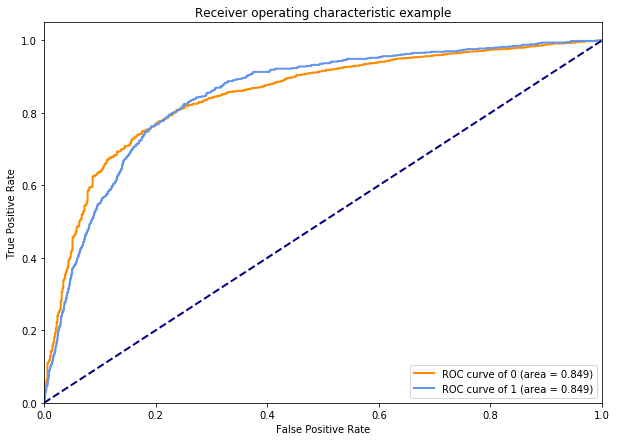


	[@] MODEL-(1/3) Training.. 

{'RNN_ARCH': {'cell_type': 'GRU', 'drop_out': [False, True], 'hidden_size': [64, 128]}, 'DECAY_RATE': 0.9, 'EMB_MATRIX': False, 'LABEL_SIZE': 2, 'EMB_SIZE': 128, 'DECAY_STEPS': 1000, 'MAX_TIME_STEP': 30, 'SAVE_BY': 1000000, 'LR': 0.0005, 'KEEP_PROB': 0.5, 'L2_REG': 0.001, 'TRAIN_STEPS': 100, 'PRINT_BY': 200, 'BATCH_SIZE': 256, 'FEATURE_SIZE': 7090, 'MODEL_ARCH': 'RNN_MODEL'}


testing..

test_examples:  4669
Loading FAILED.. 

  [ABORT !!]

	[@] MODEL-(2/3) Training.. 

{'RNN_ARCH': {'cell_type': 'GRU', 'drop_out': [False, True], 'hidden_size': [64, 128]}, 'DECAY_RATE': 0.9, 'EMB_MATRIX': False, 'LABEL_SIZE': 2, 'EMB_SIZE': 128, 'DECAY_STEPS': 1000, 'MAX_TIME_STEP': 30, 'SAVE_BY': 1000000, 'LR': 5e-05, 'KEEP_PROB': 0.5, 'L2_REG': 0.001, 'TRAIN_STEPS': 100, 'PRINT_BY': 200, 'BATCH_SIZE': 128, 'FEATURE_SIZE': 7090, 'MODEL_ARCH': 'RNN_MODEL'}


testing..

test_examples:  4669
Loading FAILED.. 

  [ABORT !!]

	[@] MODEL-(3/3) Training.. 

{'RNN_ARCH': {'cell_

In [4]:
%matplotlib inline

from Train import Test_model_list

Test_model_list(MODEL_LIST = model_list,
                DATASETS = datasets,
                RESULT_BASE_PATH = '../../RESULT/', 
                PROJECT_NAME = 'Sequence_Analyzer', 
                DB_NAME = 'NHIS_NSC')

# [1] Get datasets

## (1-1) Raw_seq to datasets 

In [1]:
from Dataset import convert_code_to_multihot, get_dataSets

DATA_PATH_DS_KNN = '/home/jin/Urim/DATA/CLAIM/CKD_DS_KNN/'
#convert_code_to_multihot(DATA_PATH_DS_KNN, max_time_step=30, dx_only=False)
datasets_DS_KNN = get_dataSets(DATA_PATH_DS_KNN, tr_ratio=0.8)

#DATA_PATH_DS_PSM = '/home/jin/Urim/DATA/CLAIM/CKD_DS_PSM/'
#convert_code_to_multihot(DATA_PATH_DS_PSM, max_time_step=30, dx_only=False)
#datasets_DS_PSM = get_dataSets(DATA_PATH_DS_PSM, tr_ratio=0.8)


datasets = datasets_DS_KNN


[Creating_dataSets]

Loading at.. /home/jin/Urim/DATA/CLAIM/CKD_DS_KNN/t_pid_list.pkl
Loading at.. /home/jin/Urim/DATA/CLAIM/CKD_DS_KNN/t_seq_data.pkl
Loading at.. /home/jin/Urim/DATA/CLAIM/CKD_DS_KNN/t_demo_data.pkl
Loading at.. /home/jin/Urim/DATA/CLAIM/CKD_DS_KNN/t_seq_len.pkl
Loading at.. /home/jin/Urim/DATA/CLAIM/CKD_DS_KNN/c_pid_list.pkl
Loading at.. /home/jin/Urim/DATA/CLAIM/CKD_DS_KNN/c_seq_data.pkl
Loading at.. /home/jin/Urim/DATA/CLAIM/CKD_DS_KNN/c_demo_data.pkl
Loading at.. /home/jin/Urim/DATA/CLAIM/CKD_DS_KNN/c_seq_len.pkl

Number of T:  3816 
Number of C:  19896

(Split data)
{'MAX_TIME_STEP': 30, 'FEATURE_SIZE': 6902, 'LABEL_SIZE': 2}


## (1-2) Inspect Cohorts (JIN_add_at_180831)

### TRAIN-TARGET

In [2]:
from Report import get_datasets_info
    
get_datasets_info(DATA_PATH = DATA_PATH_DS_KNN, 
                  DATASETS = datasets, 
                  dataset_type = 'TRAIN', #TRAIN, #TEST, #ALL
                  cohort_type = 'TARGET', #TARGET #COMP #ALL
                  topK = 15, 
                  thr = 0.1)



[TRAIN-TARGET]

[statsInfo]

  [gender level];
          male: 1747
        female: 1305
           SUM: 3052

  [avg_age info];
          nobs: 3052
        minmax: (0.013666666666666667, 0.9299999999999998)
          mean: 0.5748570336391436
      variance: 0.04482969312688375
      skewness: -0.9289425717745139
      kurtosis: -0.007024777490426182

  [visit level] sequence length;
          nobs: 3052
        minmax: (2, 30)
          mean: 27.20445609436435
      variance: 51.03193031698349
      skewness: -2.4654729118878387
      kurtosis: 4.626940950496454

  [code level] # of co-code;
          nobs: 83028
        minmax: (1, 119)
          mean: 7.23560726501903
      variance: 28.880545493414157
      skewness: 2.6303518999111923
      kurtosis: 17.52560999867853

[topK_codeFrequency]

Loading at.. /home/jin/Urim/DATA/CLAIM/CKD_DS_KNN/code2title.pkl
Loading at.. /home/jin/Urim/DATA/CLAIM/CKD_DS_KNN/code2idx.pkl

  TopK of [15] codes: 
   0. [(320128, 22509)]: Essential hyp

### TRAIN-COMP

In [3]:
from Report import get_datasets_info
    
get_datasets_info(DATA_PATH = DATA_PATH_DS_KNN, 
                  DATASETS = datasets, 
                  dataset_type = 'TRAIN', #TRAIN, #TEST, #ALL
                  cohort_type = 'COMP', #TARGET #COMP #ALL
                  topK = 15, 
                  thr = 0.1)



[TRAIN-COMP]

[statsInfo]

  [gender level];
          male: 9044
        female: 6872
           SUM: 15916

  [avg_age info];
          nobs: 15916
        minmax: (0.013666666666666667, 0.9299999999999998)
          mean: 0.5619113680154142
      variance: 0.0454131618998731
      skewness: -0.8206003929097728
      kurtosis: -0.18984771796212474

  [visit level] sequence length;
          nobs: 15916
        minmax: (2, 30)
          mean: 27.06873586328223
      variance: 52.54846389981585
      skewness: -2.3798076849473997
      kurtosis: 4.21983803586457

  [code level] # of co-code;
          nobs: 430826
        minmax: (1, 119)
          mean: 6.549486335550779
      variance: 22.607577209600322
      skewness: 2.8123427448444773
      kurtosis: 20.683086113913376

[topK_codeFrequency]

Loading at.. /home/jin/Urim/DATA/CLAIM/CKD_DS_KNN/code2title.pkl
Loading at.. /home/jin/Urim/DATA/CLAIM/CKD_DS_KNN/code2idx.pkl

  TopK of [15] codes: 
   0. [(320128, 87223)]: Essential hy

# [2] Train Model

## (2-1) Model setting

In [4]:
flag_grid = {'MODEL_ARCH': ['RNN_MODEL'],
             'batch_size': [128*2],
             'max_time_step': [datasets.info['MAX_TIME_STEP']],
             'feature_size': [datasets.info['FEATURE_SIZE']],
             'label_size': [datasets.info['LABEL_SIZE']],
             'keep_prob': [0.7],
             'emb_matrix': [False],
             'emb_size': [64*1, 64*2],
             'RNN_arch': [{'hidden_size':[32*3, 32*2], 
                           'drop_out':[False, True], 
                           'cell_type':'GRU'}],
             'l2_reg': [0.001],
             'lr': [5e-4, 5e-5],
             'decay_steps': [1000],
             'decay_rate': [0.9],
             'train_steps': [1000*10],
             'printBy': [200*10],
             'saveBy': [1000000]
            }

from Model import Get_model_list

model_list = Get_model_list(flag_grid)

  0%|          | 0/4 [00:00<?, ?it/s]


[INPUT_LAYERS]
	inputs: Tensor("Input_Layer/Inputs:0", shape=(256, 30, 6902), dtype=float32)
	labels: Tensor("Input_Layer/Labels:0", shape=(256, 2), dtype=float32)
	demo: Tensor("Input_Layer/Demo:0", shape=(256, 30, 2), dtype=float32)
	seq_lens: Tensor("Input_Layer/Seq_lens:0", shape=(256,), dtype=int32)
	keep_prob: Tensor("Input_Layer/Keep_prob:0", shape=(), dtype=float32)

[EMB_LAYERS]
	W_emb: <tf.Variable 'Inference/EMB_Layer/W_emb:0' shape=(6902, 64) dtype=float32_ref>
	emb_inputs: Tensor("Inference/EMB_Layer/Emb_inputs:0", shape=(256, 30, 64), dtype=float32)
	emb_and_demo: Tensor("Inference/EMB_Layer/emb_and_demo:0", shape=(256, 30, 66), dtype=float32)

[RNN_LAYERS]
	RNN_cells: <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x7fe6d505bc50>
	RNN_outputs: Tensor("Inference/RNN_Layer/rnn/transpose_1:0", shape=(256, 30, 64), dtype=float32)
	RNN_outputs_last: Tensor("Inference/RNN_Layer/RNN_outputs_last:0", shape=(256, 64), dtype=float32)

[PREDICTION_LAYERS]
	W_pred: <tf

 25%|██▌       | 1/4 [00:00<00:02,  1.33it/s]


[ACCUARCY]
	accuracy: Tensor("Evaluation/Accuracy:0", shape=(), dtype=float32)

[INPUT_LAYERS]
	inputs: Tensor("Input_Layer/Inputs:0", shape=(256, 30, 6902), dtype=float32)
	labels: Tensor("Input_Layer/Labels:0", shape=(256, 2), dtype=float32)
	demo: Tensor("Input_Layer/Demo:0", shape=(256, 30, 2), dtype=float32)
	seq_lens: Tensor("Input_Layer/Seq_lens:0", shape=(256,), dtype=int32)
	keep_prob: Tensor("Input_Layer/Keep_prob:0", shape=(), dtype=float32)

[EMB_LAYERS]
	W_emb: <tf.Variable 'Inference/EMB_Layer/W_emb:0' shape=(6902, 64) dtype=float32_ref>
	emb_inputs: Tensor("Inference/EMB_Layer/Emb_inputs:0", shape=(256, 30, 64), dtype=float32)
	emb_and_demo: Tensor("Inference/EMB_Layer/emb_and_demo:0", shape=(256, 30, 66), dtype=float32)

[RNN_LAYERS]
	RNN_cells: <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x7fe6d4f0e358>
	RNN_outputs: Tensor("Inference/RNN_Layer/rnn/transpose_1:0", shape=(256, 30, 64), dtype=float32)
	RNN_outputs_last: Tensor("Inference/RNN_Layer/RNN_ou

 50%|█████     | 2/4 [00:01<00:01,  1.34it/s]


[ACCUARCY]
	accuracy: Tensor("Evaluation/Accuracy:0", shape=(), dtype=float32)

[INPUT_LAYERS]
	inputs: Tensor("Input_Layer/Inputs:0", shape=(256, 30, 6902), dtype=float32)
	labels: Tensor("Input_Layer/Labels:0", shape=(256, 2), dtype=float32)
	demo: Tensor("Input_Layer/Demo:0", shape=(256, 30, 2), dtype=float32)
	seq_lens: Tensor("Input_Layer/Seq_lens:0", shape=(256,), dtype=int32)
	keep_prob: Tensor("Input_Layer/Keep_prob:0", shape=(), dtype=float32)

[EMB_LAYERS]
	W_emb: <tf.Variable 'Inference/EMB_Layer/W_emb:0' shape=(6902, 128) dtype=float32_ref>
	emb_inputs: Tensor("Inference/EMB_Layer/Emb_inputs:0", shape=(256, 30, 128), dtype=float32)
	emb_and_demo: Tensor("Inference/EMB_Layer/emb_and_demo:0", shape=(256, 30, 130), dtype=float32)

[RNN_LAYERS]
	RNN_cells: <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x7fe6d4dbc9b0>
	RNN_outputs: Tensor("Inference/RNN_Layer/rnn/transpose_1:0", shape=(256, 30, 64), dtype=float32)
	RNN_outputs_last: Tensor("Inference/RNN_Layer/RNN

 75%|███████▌  | 3/4 [00:02<00:00,  1.26it/s]


[ACCUARCY]
	accuracy: Tensor("Evaluation/Accuracy:0", shape=(), dtype=float32)

[INPUT_LAYERS]
	inputs: Tensor("Input_Layer/Inputs:0", shape=(256, 30, 6902), dtype=float32)
	labels: Tensor("Input_Layer/Labels:0", shape=(256, 2), dtype=float32)
	demo: Tensor("Input_Layer/Demo:0", shape=(256, 30, 2), dtype=float32)
	seq_lens: Tensor("Input_Layer/Seq_lens:0", shape=(256,), dtype=int32)
	keep_prob: Tensor("Input_Layer/Keep_prob:0", shape=(), dtype=float32)

[EMB_LAYERS]
	W_emb: <tf.Variable 'Inference/EMB_Layer/W_emb:0' shape=(6902, 128) dtype=float32_ref>
	emb_inputs: Tensor("Inference/EMB_Layer/Emb_inputs:0", shape=(256, 30, 128), dtype=float32)
	emb_and_demo: Tensor("Inference/EMB_Layer/emb_and_demo:0", shape=(256, 30, 130), dtype=float32)

[RNN_LAYERS]
	RNN_cells: <tensorflow.python.ops.rnn_cell_impl.MultiRNNCell object at 0x7fe6d4cb3518>
	RNN_outputs: Tensor("Inference/RNN_Layer/rnn/transpose_1:0", shape=(256, 30, 64), dtype=float32)
	RNN_outputs_last: Tensor("Inference/RNN_Layer/RNN

100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


[ACCUARCY]
	accuracy: Tensor("Evaluation/Accuracy:0", shape=(), dtype=float32)


## (2-2) Model training

In [5]:
from Train import Train_model_list

Train_model_list(MODEL_LIST = model_list,
                 DATASETS = datasets,
                 RESULT_BASE_PATH = '../RESULTS/', 
                 PROJECT_NAME = 'Sequence_Analyzer', 
                 DB_NAME = 'NHIS', 
                 new_game = True, 
                 verbose = True)


Previous Logs removed


	[@] MODEL-(0/3) Training.. 

{'label_size': 2, 'feature_size': 6902, 'max_time_step': 30, 'decay_rate': 0.9, 'keep_prob': 0.7, 'batch_size': 256, 'l2_reg': 0.001, 'emb_matrix': False, 'RNN_arch': {'drop_out': [False, True], 'cell_type': 'GRU', 'hidden_size': [96, 64]}, 'printBy': 2000, 'MODEL_ARCH': 'RNN_MODEL', 'emb_size': 64, 'saveBy': 1000000, 'train_steps': 10000, 'lr': 0.0005, 'decay_steps': 1000}



  0%|          | 0/10000 [00:00<?, ?it/s]

[@] New game..

training..



  0%|          | 1/10000 [00:02<8:16:53,  2.98s/it]

[G-1]  LOSS (1.0392/1.0374)  ACC (0.51/0.53) LR (0.000500)


 20%|██        | 2001/10000 [24:16<1:37:01,  1.37it/s]

[G-2001]  LOSS (0.5453/1.1506)  ACC (0.76/0.56) LR (0.000405)


 40%|████      | 4001/10000 [48:51<1:13:15,  1.36it/s]

[G-4001]  LOSS (0.5077/1.9215)  ACC (0.79/0.53) LR (0.000328)


 60%|██████    | 6001/10000 [1:13:04<48:41,  1.37it/s]  

[G-6001]  LOSS (0.4578/2.2526)  ACC (0.81/0.45) LR (0.000266)


 80%|████████  | 8001/10000 [1:37:11<24:17,  1.37it/s]

[G-8001]  LOSS (0.2996/2.0519)  ACC (0.91/0.46) LR (0.000215)


100%|██████████| 10000/10000 [2:01:19<00:00,  1.37it/s]


 [*] Saving checkpoints... ../RESULTS/Sequence_Analyzer/NHIS/MODEL_0

[DONE@@]

	[@] MODEL-(1/3) Training.. 

{'label_size': 2, 'feature_size': 6902, 'max_time_step': 30, 'decay_rate': 0.9, 'keep_prob': 0.7, 'batch_size': 256, 'l2_reg': 0.001, 'emb_matrix': False, 'RNN_arch': {'drop_out': [False, True], 'cell_type': 'GRU', 'hidden_size': [96, 64]}, 'printBy': 2000, 'MODEL_ARCH': 'RNN_MODEL', 'emb_size': 64, 'saveBy': 1000000, 'train_steps': 10000, 'lr': 5e-05, 'decay_steps': 1000}



  0%|          | 0/10000 [00:00<?, ?it/s]

[@] New game..

training..



  0%|          | 1/10000 [00:02<8:01:42,  2.89s/it]

[G-1]  LOSS (1.0460/1.0440)  ACC (0.50/0.52) LR (0.000050)


 20%|██        | 2001/10000 [24:26<1:37:44,  1.36it/s]

[G-2001]  LOSS (0.6047/1.0330)  ACC (0.72/0.52) LR (0.000040)


 40%|████      | 4001/10000 [48:53<1:13:18,  1.36it/s]

[G-4001]  LOSS (0.4745/1.2127)  ACC (0.80/0.54) LR (0.000033)


 60%|██████    | 6001/10000 [1:13:24<48:55,  1.36it/s]  

[G-6001]  LOSS (0.4515/1.2391)  ACC (0.80/0.48) LR (0.000027)


 80%|████████  | 8001/10000 [1:37:42<24:24,  1.36it/s]

[G-8001]  LOSS (0.4637/1.1244)  ACC (0.79/0.57) LR (0.000022)


100%|██████████| 10000/10000 [2:02:05<00:00,  1.37it/s]


 [*] Saving checkpoints... ../RESULTS/Sequence_Analyzer/NHIS/MODEL_1

[DONE@@]

	[@] MODEL-(2/3) Training.. 

{'label_size': 2, 'feature_size': 6902, 'max_time_step': 30, 'decay_rate': 0.9, 'keep_prob': 0.7, 'batch_size': 256, 'l2_reg': 0.001, 'emb_matrix': False, 'RNN_arch': {'drop_out': [False, True], 'cell_type': 'GRU', 'hidden_size': [96, 64]}, 'printBy': 2000, 'MODEL_ARCH': 'RNN_MODEL', 'emb_size': 128, 'saveBy': 1000000, 'train_steps': 10000, 'lr': 0.0005, 'decay_steps': 1000}



  0%|          | 0/10000 [00:00<?, ?it/s]

[@] New game..

training..



  0%|          | 1/10000 [00:02<8:06:18,  2.92s/it]

[G-1]  LOSS (1.3858/1.3866)  ACC (0.53/0.50) LR (0.000500)


 20%|██        | 2001/10000 [24:40<1:38:38,  1.35it/s]

[G-2001]  LOSS (0.5524/1.2357)  ACC (0.71/0.54) LR (0.000405)


 40%|████      | 4001/10000 [49:05<1:13:35,  1.36it/s]

[G-4001]  LOSS (0.5447/1.7935)  ACC (0.74/0.53) LR (0.000328)


 60%|██████    | 6001/10000 [1:13:30<48:58,  1.36it/s]  

[G-6001]  LOSS (0.4796/1.7128)  ACC (0.80/0.53) LR (0.000266)


 80%|████████  | 8001/10000 [1:37:55<24:27,  1.36it/s]

[G-8001]  LOSS (0.3972/1.7580)  ACC (0.85/0.53) LR (0.000215)


100%|██████████| 10000/10000 [2:02:21<00:00,  1.36it/s]


 [*] Saving checkpoints... ../RESULTS/Sequence_Analyzer/NHIS/MODEL_2

[DONE@@]

	[@] MODEL-(3/3) Training.. 

{'label_size': 2, 'feature_size': 6902, 'max_time_step': 30, 'decay_rate': 0.9, 'keep_prob': 0.7, 'batch_size': 256, 'l2_reg': 0.001, 'emb_matrix': False, 'RNN_arch': {'drop_out': [False, True], 'cell_type': 'GRU', 'hidden_size': [96, 64]}, 'printBy': 2000, 'MODEL_ARCH': 'RNN_MODEL', 'emb_size': 128, 'saveBy': 1000000, 'train_steps': 10000, 'lr': 5e-05, 'decay_steps': 1000}



  0%|          | 0/10000 [00:00<?, ?it/s]

[@] New game..

training..



  0%|          | 1/10000 [00:03<8:21:55,  3.01s/it]

[G-1]  LOSS (1.3994/1.4004)  ACC (0.50/0.49) LR (0.000050)


 20%|██        | 2001/10000 [24:17<1:37:07,  1.37it/s]

[G-2001]  LOSS (0.6384/0.9498)  ACC (0.71/0.55) LR (0.000040)


 40%|████      | 4001/10000 [48:39<1:12:57,  1.37it/s]

[G-4001]  LOSS (0.6110/0.9687)  ACC (0.73/0.58) LR (0.000033)


 60%|██████    | 6001/10000 [1:12:59<48:38,  1.37it/s]  

[G-6001]  LOSS (0.5107/1.1872)  ACC (0.79/0.53) LR (0.000027)


 80%|████████  | 8001/10000 [1:37:03<24:14,  1.37it/s]

[G-8001]  LOSS (0.5480/1.3134)  ACC (0.77/0.52) LR (0.000022)


100%|██████████| 10000/10000 [2:01:26<00:00,  1.37it/s]

 [*] Saving checkpoints... ../RESULTS/Sequence_Analyzer/NHIS/MODEL_3

[DONE@@]

[ALL DONE]


# [3] Eval

## (3-1) Model testing


	[@] MODEL-(0/3) Training.. 

{'label_size': 2, 'feature_size': 6902, 'max_time_step': 30, 'decay_rate': 0.9, 'keep_prob': 0.7, 'batch_size': 256, 'l2_reg': 0.001, 'emb_matrix': False, 'RNN_arch': {'drop_out': [False, True], 'cell_type': 'GRU', 'hidden_size': [96, 64]}, 'printBy': 2000, 'MODEL_ARCH': 'RNN_MODEL', 'emb_size': 64, 'saveBy': 1000000, 'train_steps': 10000, 'lr': 0.0005, 'decay_steps': 1000}


testing..

test_examples:  4744
INFO:tensorflow:Restoring parameters from /home/jin/scripts/NEW/RESULTS/Sequence_Analyzer/NHIS/MODEL_0/MODEL_0-10000
Loading SUCCESS.. 

[Report]
  Avg of batch_loss: 1.1391992717981339
  Avg of batch_acc
  AUROC of 4744-samples: 0.4799980659326291


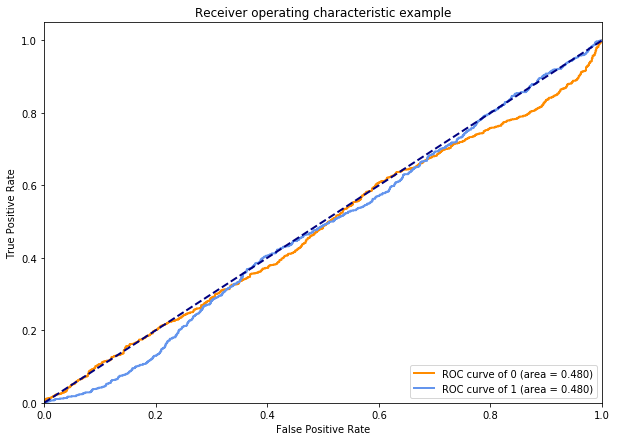


	[@] MODEL-(1/3) Training.. 

{'label_size': 2, 'feature_size': 6902, 'max_time_step': 30, 'decay_rate': 0.9, 'keep_prob': 0.7, 'batch_size': 256, 'l2_reg': 0.001, 'emb_matrix': False, 'RNN_arch': {'drop_out': [False, True], 'cell_type': 'GRU', 'hidden_size': [96, 64]}, 'printBy': 2000, 'MODEL_ARCH': 'RNN_MODEL', 'emb_size': 64, 'saveBy': 1000000, 'train_steps': 10000, 'lr': 5e-05, 'decay_steps': 1000}


testing..

test_examples:  4744
INFO:tensorflow:Restoring parameters from /home/jin/scripts/NEW/RESULTS/Sequence_Analyzer/NHIS/MODEL_1/MODEL_1-10000
Loading SUCCESS.. 

[Report]
  Avg of batch_loss: 0.8593689368830787
  Avg of batch_acc
  AUROC of 4744-samples: 0.4975863315917647


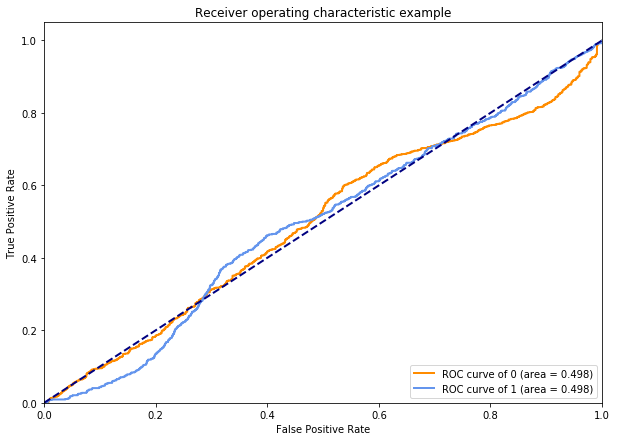


	[@] MODEL-(2/3) Training.. 

{'label_size': 2, 'feature_size': 6902, 'max_time_step': 30, 'decay_rate': 0.9, 'keep_prob': 0.7, 'batch_size': 256, 'l2_reg': 0.001, 'emb_matrix': False, 'RNN_arch': {'drop_out': [False, True], 'cell_type': 'GRU', 'hidden_size': [96, 64]}, 'printBy': 2000, 'MODEL_ARCH': 'RNN_MODEL', 'emb_size': 128, 'saveBy': 1000000, 'train_steps': 10000, 'lr': 0.0005, 'decay_steps': 1000}


testing..

test_examples:  4744
INFO:tensorflow:Restoring parameters from /home/jin/scripts/NEW/RESULTS/Sequence_Analyzer/NHIS/MODEL_2/MODEL_2-10000
Loading SUCCESS.. 

[Report]
  Avg of batch_loss: 1.1540612313482497
  Avg of batch_acc
  AUROC of 4744-samples: 0.49441001751556785


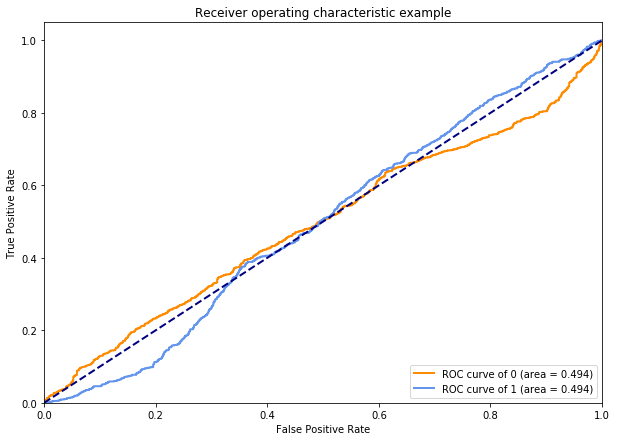


	[@] MODEL-(3/3) Training.. 

{'label_size': 2, 'feature_size': 6902, 'max_time_step': 30, 'decay_rate': 0.9, 'keep_prob': 0.7, 'batch_size': 256, 'l2_reg': 0.001, 'emb_matrix': False, 'RNN_arch': {'drop_out': [False, True], 'cell_type': 'GRU', 'hidden_size': [96, 64]}, 'printBy': 2000, 'MODEL_ARCH': 'RNN_MODEL', 'emb_size': 128, 'saveBy': 1000000, 'train_steps': 10000, 'lr': 5e-05, 'decay_steps': 1000}


testing..

test_examples:  4744
INFO:tensorflow:Restoring parameters from /home/jin/scripts/NEW/RESULTS/Sequence_Analyzer/NHIS/MODEL_3/MODEL_3-10000
Loading SUCCESS.. 

[Report]
  Avg of batch_loss: 0.9250165157847934
  Avg of batch_acc
  AUROC of 4744-samples: 0.4845467846810968


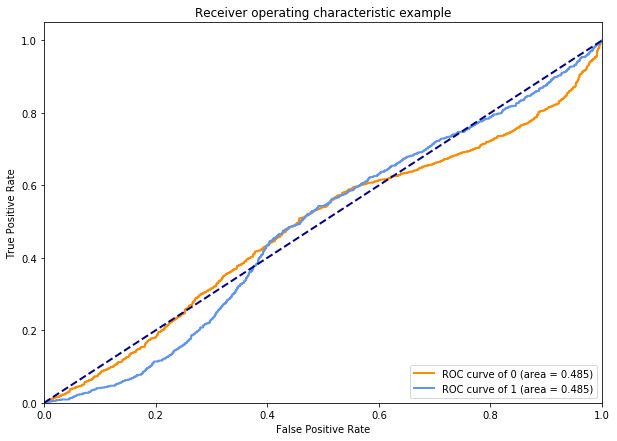

Dumping at.. ../RESULTS/Sequence_Analyzer/NHIS/df_RESULTS.pkl

[ALL DONE]


In [6]:
%matplotlib inline

from Train import Test_model_list

Test_model_list(MODEL_LIST = model_list,
                DATASETS = datasets,
                RESULT_BASE_PATH = '../RESULTS/', 
                PROJECT_NAME = 'Sequence_Analyzer', 
                DB_NAME = 'NHIS')

## (3-2) Sort models by performance

In [7]:
from Report import Results_model_list

df = Results_model_list(RESULT_BASE_PATH = '../RESULTS/', 
                   PROJECT_NAME = 'Sequence_Analyzer', 
                   DB_NAME = 'NHIS')
df

Loading at.. ../RESULTS/Sequence_Analyzer/NHIS/df_RESULTS.pkl


,Model_Index,Avg_Batch_Loss,Avg_Batch_Acc,AUROC,Flag
0,0,1.139199,0.647135,0.479998,"{'label_size': 2, 'feature_size': 6902, 'max_t..."
1,1,0.859369,0.595269,0.497586,"{'label_size': 2, 'feature_size': 6902, 'max_t..."
2,2,1.154061,0.618707,0.494410,"{'label_size': 2, 'feature_size': 6902, 'max_t..."
3,3,0.925017,0.528429,0.484547,"{'label_size': 2, 'feature_size': 6902, 'max_t..."


In [20]:
from cdm_datasetmaker import Get_datasets
datasets = Get_datasets(CONFIG_FOLDER_PATH = '../../TEST/CONFIG/',
                        DATA_FOLDER_PATH = '../../TEST/DATA/',
                        RESULT_FOLDER_PATH = '../../TEST/RESULT/',
                        PROJECT_NAME = 'emb_test',
                        DB_CONN_FILENAME = 'DB_connection.txt',
                        DS_PARAMS_FILE_NAME = 'DS_PARAMS.txt', 
                        PIPELINE_START_LEVEL = 4)



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

2018-09-27 10:49:59.444820

[Start Logging..]



 (params) 



[Level 4] Multihot to Dataset


2018-09-27 10:49:59.451965

  [multihot_to_datasets]

Loading at.. ../../TEST/DATA/t_pid_list.pkl
Loading at.. ../../TEST/DATA/t_seq_data.pkl
Loading at.. ../../TEST/DATA/t_demo_data.pkl
Loading at.. ../../TEST/DATA/t_seq_len.pkl
Loading at.. ../../TEST/DATA/c_pid_list.pkl
Loading at.. ../../TEST/DATA/c_seq_data.pkl
Loading at.. ../../TEST/DATA/c_demo_data.pkl
Loading at.. ../../TEST/DATA/c_seq_len.pkl

Number of T: 3335
Number of C: 20010

    (Split data)

    (Making datasets)

[Datasets Info.]

                  [OPTION]   [VALUE]
              CDM_DB_NAME:   NHIS_NSC
       CONFIG_FOLDER_PATH:   ../../TEST/CONFIG/
         DATA_FOLDER_PATH:   ../../TEST/DATA/
         DB_CONN_FILENAME: 

In [24]:
def get_param_dict(FILE_NAME, CONFIG_FOLDER_PATH):
    import os, re
    FILE_PATH = os.path.join(CONFIG_FOLDER_PATH, FILE_NAME)
    param_dict = dict()
    with open(FILE_PATH, 'r') as f:
        lines = f.readlines()
        for line in lines:
            try: #remove comments
                cut_idx = re.search('#.*', line).start()
                line = line[:cut_idx]
            except:
                pass
            
            particles = [p.strip() for p in line.split('=', maxsplit=1)]
            if len(particles)==1:
                continue
            key = particles[0]
            val = particles[1:] 
            
            if ',' in val[0]:
                val = [v.strip() for v in val[0].split(',')]
            try: val = [int(v) for v in val]
            except:
                try: val = [float(v) for v in val]
                except:
                    val = [True if v.lower()=='true' else False if v.lower()=='false' else v for v in val]
            param_dict[key] = val
    return param_dict


import os
    
kwargs = {'CONFIG_FOLDER_PATH': '../CONFIG/', 
          'RESULT_FOLDER_PATH': '../RESULT/',
          'PROJECT_NAME': 'project_emb', 
          'EMB_PARAMS_FILE_NAME': 'EMB_PARAMS_TEST.txt',
          'DATASETS': datasets,
          'SKIP_EDGE_EXTRACTING': True,
          'NEW_GAME': True}

param_dict = get_param_dict(kwargs['EMB_PARAMS_FILE_NAME'], kwargs['CONFIG_FOLDER_PATH'])
param_dict.update(kwargs)

param_dict['DUMPING_PATH'] = os.path.join(param_dict['RESULT_FOLDER_PATH'], 
                                          param_dict['PROJECT_NAME'], 
                                          param_dict['DATASETS'].info['CDM_DB_NAME'])
param_dict

{'CDM_DB_NAME': ['NHIS_NSC'],
 'LEFT_CONTEXT_SIZE': [2],
 'RIGHT_CONTEXT_SIZE': [2],
 'DIRECTED': [False],
 'MODEL_ARCH': ['LINE_MODEL'],
 'BATCH_SIZE': [128],
 'EMB_SIZE': [32, 64],
 'LR_p1': [0.5, 0.05],
 'DECAY_STEPS': [1000],
 'DECAY_RATE': [0.9],
 'TRAIN_STEPS_p1': [1000],
 'TRAIN_STEPS_p2': [1000],
 'PRINT_BY': [2000],
 'CONFIG_FOLDER_PATH': '../CONFIG/',
 'RESULT_FOLDER_PATH': '../RESULT/',
 'PROJECT_NAME': 'project_emb',
 'EMB_PARAMS_FILE_NAME': 'EMB_PARAMS_TEST.txt',
 'DATASETS': <cdm_datasetmaker.multihot2datasets.multihot_to_datasets.<locals>.DATASETS at 0x123009f60>,
 'SKIP_EDGE_EXTRACTING': True,
 'NEW_GAME': True,
 'DUMPING_PATH': '../RESULT/project_emb/NHIS_NSC'}

In [25]:
def param_dict_to_flag_grid(param_dict):
    flag_grid = dict()    
    for k, v in param_dict.items():
        if k in ['DATASETS', 'NEW_GAME', 'CONFIG_FOLDER_PATH', 'RESULT_FOLDER_PATH', 
                 'LEFT_CONTEXT_SIZE', 'RIGHT_CONTEXT_SIZE', 'DIRECTED', 'SKIP_EDGE_EXTRACTING',
                 'PROJECT_NAME', 'EMB_PARAMS_FILE_NAME']:
            continue
        if k=='DUMPING_PATH':
            flag_grid[k] = [v]
        else:
            flag_grid[k] = v
    return flag_grid

flag_grid = param_dict_to_flag_grid(param_dict)
flag_grid

{'CDM_DB_NAME': ['NHIS_NSC'],
 'MODEL_ARCH': ['LINE_MODEL'],
 'BATCH_SIZE': [128],
 'EMB_SIZE': [32, 64],
 'LR_p1': [0.5, 0.05],
 'DECAY_STEPS': [1000],
 'DECAY_RATE': [0.9],
 'TRAIN_STEPS_p1': [1000],
 'TRAIN_STEPS_p2': [1000],
 'PRINT_BY': [2000],
 'DUMPING_PATH': ['../RESULT/project_emb/NHIS_NSC']}

In [26]:
def get_flag_list(flag_grid, FEATURE_SIZE):
    #update flag_grid 
    flag_grid['FEATURE_SIZE'] = [FEATURE_SIZE]
    
    #flag_grid to flag_list
    from itertools import product
    flag_list = [dict(list(zip(list(flag_grid.keys()), values))) 
                 for values in list(product(*flag_grid.values()))]
    
    #remove duplicated flag
    flag_list_new_unique = []
    for d_item in flag_list:
        if d_item not in flag_list_new_unique:
            flag_list_new_unique.append(d_item)
    return flag_list_new_unique
            
flag_list_new_unique = get_flag_list(flag_grid, param_dict['DATASETS'].info['FEATURE_SIZE'])
flag_list_new_unique

[{'CDM_DB_NAME': 'NHIS_NSC',
  'MODEL_ARCH': 'LINE_MODEL',
  'BATCH_SIZE': 128,
  'EMB_SIZE': 32,
  'LR_p1': 0.5,
  'DECAY_STEPS': 1000,
  'DECAY_RATE': 0.9,
  'TRAIN_STEPS_p1': 1000,
  'TRAIN_STEPS_p2': 1000,
  'PRINT_BY': 2000,
  'DUMPING_PATH': '../RESULT/project_emb/NHIS_NSC',
  'FEATURE_SIZE': 7085},
 {'CDM_DB_NAME': 'NHIS_NSC',
  'MODEL_ARCH': 'LINE_MODEL',
  'BATCH_SIZE': 128,
  'EMB_SIZE': 32,
  'LR_p1': 0.05,
  'DECAY_STEPS': 1000,
  'DECAY_RATE': 0.9,
  'TRAIN_STEPS_p1': 1000,
  'TRAIN_STEPS_p2': 1000,
  'PRINT_BY': 2000,
  'DUMPING_PATH': '../RESULT/project_emb/NHIS_NSC',
  'FEATURE_SIZE': 7085},
 {'CDM_DB_NAME': 'NHIS_NSC',
  'MODEL_ARCH': 'LINE_MODEL',
  'BATCH_SIZE': 128,
  'EMB_SIZE': 64,
  'LR_p1': 0.5,
  'DECAY_STEPS': 1000,
  'DECAY_RATE': 0.9,
  'TRAIN_STEPS_p1': 1000,
  'TRAIN_STEPS_p2': 1000,
  'PRINT_BY': 2000,
  'DUMPING_PATH': '../RESULT/project_emb/NHIS_NSC',
  'FEATURE_SIZE': 7085},
 {'CDM_DB_NAME': 'NHIS_NSC',
  'MODEL_ARCH': 'LINE_MODEL',
  'BATCH_SIZE': 128

In [27]:
import tensorflow as tf
import numpy as np

def get_logger_instance(logger_name, DUMPING_PATH, parent_name=False, stream=False):
    import logging, os, sys, datetime
    if parent_name:
        logger = logging.getLogger(parent_name+'.'+logger_name)
    else:
        logger = logging.getLogger(logger_name)
    logger.setLevel(logging.INFO)
    
    #stream_handler
    if stream:
        stream_hander = logging.StreamHandler(sys.stdout)
        logger.addHandler(stream_hander)
    
    #file_handler  
    if parent_name:
        logFilePath = os.path.join(DUMPING_PATH, parent_name+'_'+logger_name+'.log')
    else:
        logFilePath = os.path.join(DUMPING_PATH, logger_name+'.log')
    file_handler = logging.FileHandler(filename=logFilePath)
    logger.addHandler(file_handler)
    
    if parent_name==False:
        logger.info("\n\n" + "@"*100 + "\n" + "@"*100)
        logger.info("\n{}".format(datetime.datetime.now()))
        logger.info("\n[Start Logging..]\n\n")    
    return logger

class LINE_MODEL():
    def __init__(self, flag):
        self.flag = flag
        self.tensorDict = dict()
        self.resultDict = dict()
        self.g = tf.Graph()
        self.g_vis = tf.Graph()
        self.Building_graph()
        
    def _get_logger(self):
        #from .utils import get_logger_instance
        self.logger = get_logger_instance(logger_name=self.flag['MODEL_NAME'], 
                                          DUMPING_PATH=self.flag['DUMPING_PATH'])
        
    def _basic_tensors(self):
        with tf.name_scope('Learning_Rate'):    
            self.tensorDict['global_step'] = tf.Variable(0, name="Global_step", trainable=False, dtype=tf.int32)
            if ('DECAY_STEPS' in self.flag.keys())&('DECAY_RATE' in self.flag.keys()):
                self.tensorDict['lr_p1'] = tf.train.exponential_decay(self.flag['LR_p1'], self.tensorDict['global_step'], 
                                                               self.flag['DECAY_STEPS'], self.flag['DECAY_RATE'], 
                                                               staircase=True, name='ExpDecay_lr_p1')
                self.tensorDict['lr_p2'] = tf.train.exponential_decay(self.flag['LR_p2'], self.tensorDict['global_step'], 
                                                               self.flag['DECAY_STEPS'], self.flag['DECAY_RATE'], 
                                                               staircase=True, name='ExpDecay_lr_p2')
            else:
                self.tensorDict['lr_p1'] = tf.constant(self.flag['LR_p1'], name='Constant_lr_p1')
                self.tensorDict['lr_p2'] = tf.constant(self.flag['LR_p2'], name='Constant_lr_p2')
                
    def _input_layer_tensors(self):
        with tf.name_scope('Input_Layer'):
            self.tensorDict['focus_w'] = tf.placeholder(tf.int32, shape=[self.flag['BATCH_SIZE']], name='focus_w')
            self.tensorDict['context_w'] = tf.placeholder(tf.int32, shape=[self.flag['BATCH_SIZE']], name='context_w')
            self.tensorDict['score'] = tf.placeholder(tf.float32, shape=[self.flag['BATCH_SIZE']], name='score')
            
    def _embedding_layer_tensors(self):
        with tf.name_scope('EMB_Layer'):
            ## p1
            self.tensorDict['p1_emb_matrix'] = tf.Variable(tf.random_uniform([self.flag['FEATURE_SIZE'], self.flag['EMB_SIZE']], 
                                                                             -0.01, 0.01), 
                                                           name='p1_emb_matrix')
            self.tensorDict['p1_focus_emb_vec'] = tf.nn.embedding_lookup(self.tensorDict['p1_emb_matrix'],
                                                                         self.tensorDict['focus_w'], 
                                                                         name='p1_focus_emb_vec')
            self.tensorDict['p1_context_emb_vec'] = tf.nn.embedding_lookup(self.tensorDict['p1_emb_matrix'],
                                                                           self.tensorDict['context_w'], 
                                                                           name='p1_context_emb_vec')
            
            ## p2
            self.tensorDict['p2_emb_focus_matrix'] = tf.Variable(tf.random_uniform([self.flag['FEATURE_SIZE'], 
                                                                                    self.flag['EMB_SIZE']], -0.01, 0.01), 
                                                                 name='p2_emb_focus_matrix')
            self.tensorDict['p2_focus_emb_vec'] = tf.nn.embedding_lookup(self.tensorDict['p2_emb_focus_matrix'], 
                                                                         self.tensorDict['focus_w'],
                                                                         name='p2_focus_emb_vec')
            
            self.tensorDict['p2_emb_context_matrix'] = tf.Variable(tf.random_uniform([self.flag['FEATURE_SIZE'], 
                                                                                      self.flag['EMB_SIZE']], 
                                                                             -0.01, 0.01), 
                                                                   name='p2_emb_context_matrix')
            self.tensorDict['p2_context_emb_vec'] = tf.nn.embedding_lookup(self.tensorDict['p2_emb_context_matrix'],
                                                                           self.tensorDict['context_w'],
                                                                           name='p2_context_emb_vec')
    
    def _Inference(self):        
        with tf.name_scope('Inference'):
            self._embedding_layer_tensors()
        
    def _Loss(self):
        with tf.variable_scope('Loss'):
            with tf.name_scope('First-order_proximity'):
                p1_inner_product = tf.reduce_sum((self.tensorDict['p1_focus_emb_vec'] * self.tensorDict['p1_context_emb_vec']), 
                                                 axis=1, name='p1_inner_product')
                p1_logits = tf.nn.sigmoid(p1_inner_product, name='p1_logits')
                self.tensorDict['loss_1st_prox'] = tf.reduce_mean(-self.tensorDict['score']*tf.log(p1_logits+1e-10), 
                                                                  name='loss_1st_prox')

            with tf.name_scope('Second-order_proximity'):
                p2_inner_product = tf.reduce_sum((self.tensorDict['p2_focus_emb_vec'] * self.tensorDict['p2_context_emb_vec']), 
                                                 axis=1, name='p2_inner_product')
                #issue; add negative sampling
                p2_numerator = tf.exp(p2_inner_product, name='p2_numerator')
                p2_denominator = tf.reduce_sum(tf.exp(tf.matmul(self.tensorDict['p2_focus_emb_vec'], 
                                                                tf.transpose(self.tensorDict['p2_emb_context_matrix']))) + 1e-10, 
                                               axis=1, name='p2_denominator') 
                p2_logits = tf.divide(p2_numerator, p2_denominator, name='p2_logits')
                self.tensorDict['loss_2nd_prox'] = tf.reduce_mean(-self.tensorDict['score']*tf.log(p2_logits+1e-10), 
                                                                  name='loss_2nd_prox')
                        
    def _Optimizer(self):
        with tf.name_scope('Optimizer_p1'):       
            optimizer_p1 = tf.train.AdamOptimizer(self.tensorDict['lr_p1'], name='optimizer_p1')
            self.tensorDict['trainOp_p1'] = optimizer_p1.minimize(self.tensorDict['loss_1st_prox'], 
                                                                  global_step=self.tensorDict['global_step'])
        with tf.name_scope('Optimizer_p2'):       
            optimizer_p2= tf.train.AdamOptimizer(self.tensorDict['lr_p2'], name='optimizer_p2')
            self.tensorDict['trainOp_p2'] = optimizer_p2.minimize(self.tensorDict['loss_2nd_prox'], 
                                                                  global_step=self.tensorDict['global_step'])
            
    def _Summary(self):
        ## logging
        self.logger.info("\n[FLAG]")
        for k, v in self.flag.items():
            self.logger.info("\t{}:  {}".format(k, v))
            
        self.logger.info("\n[INPUT_LAYERS]")
        self.logger.info("\tfocus_w: {}".format(self.tensorDict['focus_w']))
        self.logger.info("\tcontext_w: {}".format(self.tensorDict['context_w']))
        self.logger.info("\tscore: {}".format(self.tensorDict['score']))
        
        self.logger.info("\n[EMB_LAYERS]")
        self.logger.info("\tp1_emb_matrix: {}".format(self.tensorDict['p1_emb_matrix']))
        self.logger.info("\tp1_focus_emb_vec: {}".format(self.tensorDict['p1_focus_emb_vec']))
        self.logger.info("\tp1_context_emb_vec: {}".format(self.tensorDict['p1_context_emb_vec']))
        self.logger.info("\tp2_emb_focus_matrix: {}".format(self.tensorDict['p2_emb_focus_matrix']))
        self.logger.info("\tp2_focus_emb_vec: {}".format(self.tensorDict['p2_focus_emb_vec']))
        self.logger.info("\tp2_emb_context_matrix: {}".format(self.tensorDict['p2_emb_context_matrix']))
        self.logger.info("\tp2_context_emb_vec: {}".format(self.tensorDict['p2_context_emb_vec']))
                    
        self.logger.info("\n[LOSS]")
        self.logger.info("\tloss_1st_prox: {}".format(self.tensorDict['loss_1st_prox']))
        self.logger.info("\tloss_2nd_prox: {}".format(self.tensorDict['loss_2nd_prox']))
        
        ## summary
        tf.summary.scalar('lr_p1', self.tensorDict['lr_p1'])
        tf.summary.scalar('lr_p2', self.tensorDict['lr_p2'])
        tf.summary.scalar('loss_1st_prox', self.tensorDict['loss_1st_prox'])
        tf.summary.scalar('loss_2nd_prox', self.tensorDict['loss_2nd_prox'])
        
    def Building_graph(self):
        with self.g.as_default():
            self._basic_tensors()
            self._input_layer_tensors()
            self._Inference()
            self._Loss()
            self._Optimizer()
            self._get_logger()
            self._Summary()

def get_model_list(param_dict):
    ##make flag_list
    flag_grid = param_dict_to_flag_grid(param_dict)
    flag_list = get_flag_list(flag_grid, param_dict['DATASETS'].info['FEATURE_SIZE'])
    
    ##get model_list
    MODEL_DICT = {'LINE_MODEL': LINE_MODEL}
    
    model_list = []
    for m_idx, flag in enumerate(flag_list):
        flag['MODEL_NAME'] = 'MODEL_{}'.format(m_idx+1)
        model_list.append(MODEL_DICT[flag['MODEL_ARCH']](flag))
    return model_list

model_list = get_model_list(param_dict)
model_list

KeyError: 'LR_p2'